In [1]:
#Импорт необходимых библиотек
import numpy as np
from numpy import random 
from keras.datasets import mnist
from skimage.io import imshow
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [192]:
def compute_loss(y_true, y_pred):
    loss  = -1* y_true * np.log(y_pred + 1e-12) -(1- y_true) * np.log(1 - y_pred + 1e-12) 
    #loss = (y_true-y_pred)**2
    return loss

def invert_result(choose_two_classes, pred):
    if pred == 0 :
        pred = choose_two_classes[1]
    else:
        pred = choose_two_classes[0]
    return pred

In [261]:
#Класс перцептрона
class Perceptron(object):

    def __init__(self, num_inputs, threshold, learning_rate, choose_two_classes):
        self.threshold = threshold #Задаем количество итераций для обучения
        self.learning_rate = learning_rate #Задаем темп обучения
        self.weights = np.zeros(num_inputs + 1) #Задаем входное количество признаков
        self.class1 = choose_two_classes[0] # 9
        self.class2 = choose_two_classes[1] # 8
        
    def predict(self, inputs): #модуль предсказания
        # np.dot(inputs, self.weights[1:]) - произведение входных признаков на веса
        # self.weights[0] - байес
        summation = np.dot(inputs, self.weights[1:]) + self.weights[0] # функция суммирования
        
        #Реализуем пороговую функцию активации
        if summation > 0:
            activation = 1
        else:
            activation = 0         
        return activation
    
    def choose_right_answer(self ,label , prediction):
        ans = 0
        if label - prediction != 0:
            if label == self.class1 and prediction == self.class2:
                ans = 1 # в таком случае мы хотим чтобы с большей вероятностью выдавался класс 1
                #для этого необходимо чтобы функция summation была > 0, поэтому увеличиваем веса
            if label == self.class2 and prediction == self.class1:
                ans = -1 # в таком случае мы хотим чтобы с большей вероятностью выдавался класс 2
                #для этого необходимо чтобы функция summation была < 0, поэтому уменьшаем веса
        return ans

    def train(self, training_inputs, labels, choose_two_classes, val_data ,val_labels): #модуль обучения
        tr_LOSS = []
        tr_ACC_on_iter = []
        train_loss = 0
        label_bin = labels
        label_bin[label_bin == self.class1] = 1
        label_bin[label_bin == self.class2] = 0
        sum_pred = 0
        sum_label = 0
        val_LOSS = []
        val_ACC_on_iter = []
        for  in range(self.threshold):
            for inputs, label in zip(training_inputs, label_bin): #для каждой пары объект - класс
                prediction = self.predict(inputs) #предсказываем класс изображения
                #обновляем веса по дельта-правилу
                self.weights[1:] += self.learning_rate * (label - prediction) * inputs 
                self.weights[0] += self.learning_rate * (label - prediction) #обновляем байес
                if (label - prediction) == 0:
                    sum_pred += 1
                sum_label += 1
                train_loss += 1/len(training_inputs) * compute_loss(label, prediction)
            tr_LOSS.append(train_loss) 
            tr_ACC_on_iter.append(1- abs(sum_pred-sum_label)/sum_label)
            train_loss = 0
            acc_val, val_loss = self.validate(choose_two_classes,val_data, val_labels)
            val_LOSS.append(val_loss) 
            val_ACC_on_iter.append(acc_val)
            print(t, end='\r')
        tr_acc_res = 1- abs(sum_pred-sum_label)/sum_label
        print(t)
        return tr_ACC_on_iter , tr_acc_res, tr_LOSS , val_LOSS, val_ACC_on_iter
    
    def return_weights(self):
        return self.weights #возвращаем вектор весов
    
    def validate(self, choose_two_classes,val_data, val_labels):
        sum_pred = 0
        sum_label = 0
        ACC_val = 0
        val_loss = 0
        
        for i in range(len(val_data)):
            pred = self.predict(val_data[i])
            if invert_result(choose_two_classes, pred) == val_labels[i]:
                sum_pred += 1
            sum_label += 1 
            if val_labels[i] == choose_two_classes[0]:
                val_loss += 1/len(val_data) * compute_loss(1, pred)
            elif val_labels[i] == choose_two_classes[1] :
                val_loss += 1/len(val_data) * compute_loss(0, pred)
        ACC_val = (1 - abs(sum_pred-sum_label)/sum_label)
        
        return ACC_val, val_loss

In [263]:
#Загружаем MNIST
(x_train, y_train), (x_test, y_test) = mnist.load_data()
choose_two_classes =  [9,8] #Задаем желаемые классы цифр для обучения / теста

idx_to_train = np.where(np.logical_or(y_train==choose_two_classes[0], y_train==choose_two_classes[1]))
idx_to_val = np.where(np.logical_or(y_test==choose_two_classes[0], y_test==choose_two_classes[1]))

x_train_red , y_train_red = x_train[idx_to_train] , y_train[idx_to_train]
x_test_red , y_test_red = x_test[idx_to_val] , y_test[idx_to_val]

x_train_red.shape , y_train_red.shape , x_test_red.shape , y_test_red.shape

((11800, 28, 28), (11800,), (1983, 28, 28), (1983,))

In [264]:
#Разбиваем данные на обучающую и валидационую выборки

#Перемещиваем данные
idx = np.random.permutation(len(x_train_red))
data, tr_labels = x_train_red[idx], y_train_red[idx]
val_labels = y_test_red

# Делаем исходные картинки плоскими и формуриуем обучающую и валидационную выборки
tr_data = []
for i in range(len(data)):
    tr_data.append(data[i].flatten())

val_data = []
for i in range(len(x_test_red)):
    val_data.append(x_test_red[i].flatten())
    
tr_data = np.array(tr_data) 
val_data = np.array(val_data)    


tr_data.shape, val_data.shape , idx

((11800, 784), (1983, 784), array([1187, 8704, 9092, ..., 8110, 5449, 6549]))

Результирующая точность на обучении 0.9826838983050847


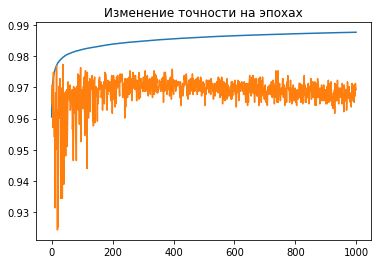

In [273]:
#Процесс обучения
threshold = 1000
learning_rate= 0.0001

perceptron = Perceptron(len(tr_data[0]), threshold, learning_rate, choose_two_classes)
tr_ACC_on_iter , tr_acc_res, tr_LOSS , val_LOSS, val_ACC_on_iter  = \
perceptron.train(tr_data, tr_labels, choose_two_classes, val_data, val_labels)
print(f"Результирующая точность на обучении {acc_res}")
plt.title("Изменение точности на эпохах")
plt.plot(tr_ACC_on_iter)
plt.plot(val_ACC_on_iter)

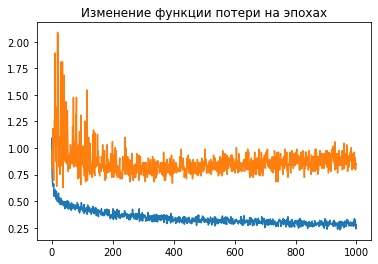

In [274]:
plt.title("Изменение функции потери на эпохах")
plt.plot(tr_LOSS)
plt.plot(val_LOSS)

Испытание 0: предсказанный результат 9, правильное значение 9
Испытание 24 c ошибкой: предсказанный результат 8, правильное значение 9
Испытание 39 c ошибкой: предсказанный результат 8, правильное значение 9
Испытание 47 c ошибкой: предсказанный результат 8, правильное значение 9
Испытание 55 c ошибкой: предсказанный результат 8, правильное значение 9
Испытание 56 c ошибкой: предсказанный результат 8, правильное значение 9
Испытание 79 c ошибкой: предсказанный результат 8, правильное значение 9
Испытание 100: предсказанный результат 8, правильное значение 8
Испытание 135 c ошибкой: предсказанный результат 9, правильное значение 8
Испытание 153 c ошибкой: предсказанный результат 8, правильное значение 9
Испытание 160 c ошибкой: предсказанный результат 8, правильное значение 9
Испытание 178 c ошибкой: предсказанный результат 8, правильное значение 9
Испытание 200: предсказанный результат 9, правильное значение 9
Испытание 206 c ошибкой: предсказанный результат 8, правильное значение 9
Ис

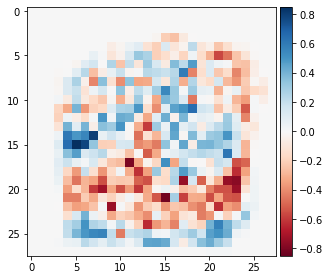

In [272]:
#Предсказываем значения на значениях весов из последней итерации
sum_pred = 0
sum_label = 0

for i in range(len(val_data)):
    if i % 100 == 0 :
        print(f"Испытание {i}: предсказанный результат {invert_result(choose_two_classes, perceptron.predict(val_data[i]))}\
, правильное значение {val_labels[i]}")
        
    if invert_result(choose_two_classes, perceptron.predict(val_data[i])) == val_labels[i]:
        sum_pred += 1
    else:
        print(f"Испытание {i} c ошибкой: предсказанный результат {invert_result(choose_two_classes, perceptron.predict(val_data[i]))}\
, правильное значение {val_labels[i]}")
    sum_label += 1 
        
print (f"Значение средней тоности составило {(1 - abs(sum_pred-sum_label)/sum_label) * 100}%")
# Смотрим распределние весов
w = perceptron.weights[1:]
imshow(w.reshape(28,28))